In [12]:
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

import plot

pd.options.mode.chained_assignment = None # turns off pandas SettingWithCopyWarning

In [13]:
figure_dir = '../../figures/submission_june_21/'
F = pd.read_csv(f'{figure_dir}/all_feature_data_for_parents_path_reports.tsv', sep='\t')
F.shape
F.head()

(6456665, 13)

,path,path category,coefficient,coefficient product,baseline path score,label,normalized coefficient,top10 path score,random,bmk confidence,bmk category,experiment,query_triple
0,alexander_ii_of_russia--children--grand_duches...,**P--has_child->C,0.708661,3.073407,4.336922,1,1.000000,4.336922,0,1.0,parent--child,"sibling false, child true",grand_duchess_alexandra_alexandrovna_of_russia...
1,grand_duchess_alexandra_alexandrovna_of_russia...,**C--has_parent->CP,0.519994,2.082942,4.005703,1,0.733770,4.005703,0,0.5,coparent--child,"sibling false, child true",grand_duchess_alexandra_alexandrovna_of_russia...
2,alexander_ii_of_russia--parents--nicholas_i_of...,P--has_parent->X,0.094594,0.310207,0.000000,0,0.133482,0.000000,0,0.0,non-benchmark,"sibling false, child true",grand_duchess_alexandra_alexandrovna_of_russia...
3,grand_duchess_alexandra_alexandrovna_of_russia...,C--gender--X,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.0,non-benchmark,"sibling false, child true",grand_duchess_alexandra_alexandrovna_of_russia...
4,grand_duchess_alexandra_alexandrovna_of_russia...,C--has_parent->X--has_child->P,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.0,non-benchmark,"sibling false, child true",grand_duchess_alexandra_alexandrovna_of_russia...


In [14]:
experiment_mapping = {'sibling false, child false':'FB13, Child=False',
 'sibling false, child true': 'FB13, Child=True',
 'sibling true, child false': 'FB14, Child=False'}

F['experiment'] = F['experiment'].map(experiment_mapping)

In [15]:
# load one-sibling benchmark and restrict dataframe to these triples
with open('../../data/commonsense_benchmark/v5/commonsense_benchmark_one_sibling.json', 'r') as f:
    benchmark = json.load(f)

one_sibling_triples = ['--'.join(b['query_triple']) for b in benchmark]
F1 = F[F['query_triple'].isin(one_sibling_triples)]
print(f'Restricted feature data to {F1.shape[0]} rows')

Restricted feature data to 1174355 rows


In [16]:
F.head()

,path,path category,coefficient,coefficient product,baseline path score,label,normalized coefficient,top10 path score,random,bmk confidence,bmk category,experiment,query_triple
0,alexander_ii_of_russia--children--grand_duches...,**P--has_child->C,0.708661,3.073407,4.336922,1,1.000000,4.336922,0,1.0,parent--child,"FB13, Child=True",grand_duchess_alexandra_alexandrovna_of_russia...
1,grand_duchess_alexandra_alexandrovna_of_russia...,**C--has_parent->CP,0.519994,2.082942,4.005703,1,0.733770,4.005703,0,0.5,coparent--child,"FB13, Child=True",grand_duchess_alexandra_alexandrovna_of_russia...
2,alexander_ii_of_russia--parents--nicholas_i_of...,P--has_parent->X,0.094594,0.310207,0.000000,0,0.133482,0.000000,0,0.0,non-benchmark,"FB13, Child=True",grand_duchess_alexandra_alexandrovna_of_russia...
3,grand_duchess_alexandra_alexandrovna_of_russia...,C--gender--X,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.0,non-benchmark,"FB13, Child=True",grand_duchess_alexandra_alexandrovna_of_russia...
4,grand_duchess_alexandra_alexandrovna_of_russia...,C--has_parent->X--has_child->P,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.0,non-benchmark,"FB13, Child=True",grand_duchess_alexandra_alexandrovna_of_russia...


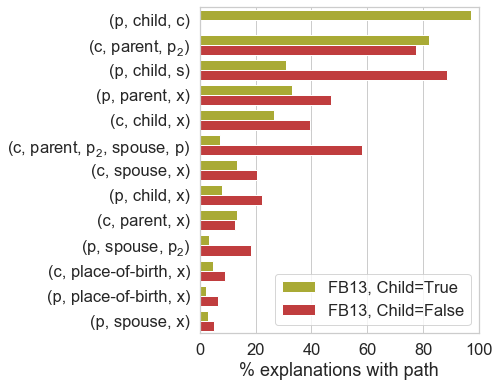

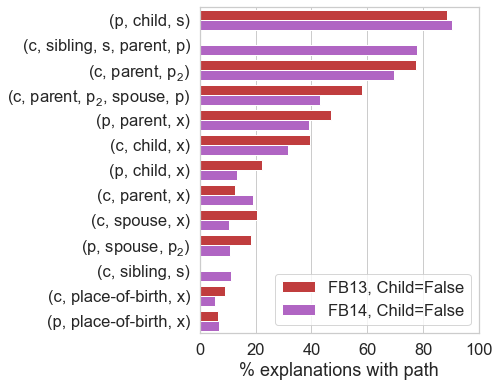

In [23]:
import plot
score_column = 'coefficient'
path_column = 'path category'
palette = {'FB13, Child=False':'tab:red',
 'FB13, Child=True': 'tab:olive',
 'FB14, Child=False': 'mediumorchid'}

plot.incidents_per_path_category(F1, experiments=['FB13, Child=True', 'FB13, Child=False'], min_count=None, figsize=(5, 6), topk=13, update_path_ctg=True, percent=True, 
                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp1_2_NoSibling_RemoveChild.png')
plot.incidents_per_path_category(F1, experiments=['FB13, Child=False', 'FB14, Child=False'], min_count=None, figsize=(5, 6), topk=13, update_path_ctg=True, percent=True,
                                  palette=palette, score_column=score_column, path_column=path_column, filename=f'{figure_dir}Exp2_3_NoChild_AddSibling.png')

In [5]:
update_path_ctg = True
percent = True

experiments = ['sibling false, child true', 'sibling false, child false']
min_count = None

fdata = F1.copy()

if experiments is not None:
    fdata = fdata[fdata['experiment'].isin(experiments)]
    
#xcol1 = 'positive'
#xcol2 = '# explanations with at least one path from category'

fdata['positive'] = fdata[score_column] > 0
fdata_summary = fdata.groupby(['experiment', 'query_triple',path_column], as_index=False)['positive'].any()
fdata_summary = fdata_summary.groupby(['experiment', path_column], as_index=False)['positive'].sum()

if percent:
    num_triples = len(set(fdata['query_triple']))
    fdata_summary['percent'] = 100 * (fdata_summary['positive'] / num_triples)
    xcol1 = 'percent'
    xcol2 = 'percent explanations with path'
else:
    xcol1 = 'positive'
    xcol2 = 'number explanations with path'

if min_count:
    fdata_summary = fdata_summary[fdata_summary['positive']>=min_count]
    
if update_path_ctg:
    fdata_summary[path_column] = fdata_summary[path_column].map(lambda x: clean_path_category(x))
    
category_means = fdata_summary.groupby(path_column)[xcol1].mean()
category_order = list(category_means.sort_values(ascending=False).index)

ctg = category_order[:10]

plt.figure(figsize=(5,6))

p = sns.barplot(data=fdata_summary, x=xcol1, y=path_column, hue='experiment', order=ctg, palette=palette, hue_order=experiments)
_ = p.legend(loc='lower right')
_ = p.set_ylabel(None)
p.set_xlabel(xcol2)

NameError: name 'clean_path_category' is not defined

In [ ]:
len(set(fdata['query_triple']))